### writes 'coords_interp'  -  coordinate file similar to 'coords'
-  Differences:  regular grid, no wall

file format:  
-  npt, ne  (number of points, number of edges)
-  for i in npt:  x(i), y(i), z(i)   
-  loop over cells (j,k):  
     write node numbers surrounding cell, counterclockwise from lower left

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pylab as plt
import numpy as np

In [3]:
ncol = 94
nrow = 63

In [4]:
npt =(ncol+1)*(nrow+1)
ne = nrow*ncol

In [5]:
# for n in range(npt):
#     print x[n], y[n], z[n]

In [6]:
nodes = np.arange(1, npt+1, dtype = int).reshape([ncol+1, nrow+1])
# (ncol+1) by (nrow+1)  -  node numbers

In [7]:
nop = np.zeros([ncol+1, nrow+1, 4], dtype = int)
for j in range(ncol):
    for k in range(nrow):
        nop[j+1, k+1] =  nodes[j,k], nodes[j+1, k], nodes[j+1,k+1], nodes[j,k+1]

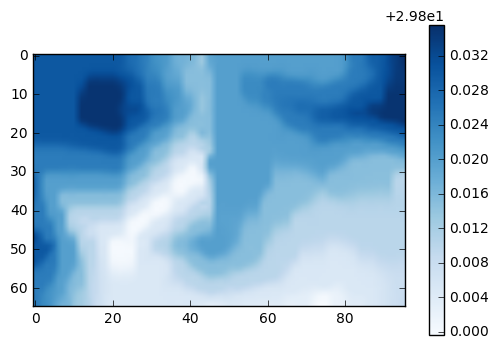

In [8]:
# 'mycoords_py.out' is created in the notebook grid set up.
# it's an interpolated version of the coordinate file (with the damn removed.)
xc =  np.zeros([ ncol+2, nrow+2])
yc =  np.zeros([ ncol+2, nrow+2])
zc =  np.zeros([ ncol+2, nrow+2])

for line in open("coords_interp.out", 'r'):
        a = (line.strip().split(" "))
        a = [float(b) for b in a if b]
        j = int(a[0])
        k = int(a[1])
        try:
            xc[j,k] = a[2]
            yc[j,k] = a[3]
            zc[j,k] = a[4]
        except IndexError:
            print a

plt.imshow(zc.T, cmap = 'Blues')
plt.colorbar()

In [9]:
nbcell = ncol*2+nrow*2 -4
xdum = np.arange(10.125, 199.125, 2 )
ydum = np.arange(9, 137, 2)
ydum, xdum = np.meshgrid(ydum, xdum)

x = np.zeros(npt + 1)
y = np.zeros(npt + 1)
z = np.zeros(npt + 1)
x[1:] = xdum.ravel()
y[1:] = ydum.ravel()

In [10]:
def transform(x, y):
    """
    To interpolate from a 2D to 1D arrays, we need a new transform function. 
    Output = j1, k1 : interpolation indices
            w1, w2, w3, w4 = interpolation weights
    """
    global j1, k1, w1, w2, w3, w4
    file = open("weights_interp.out", "w")
    j1 = np.zeros(npt+1, dtype = int)
    k1 = np.zeros(npt+1, dtype = int)
    w1 = np.zeros(npt+1, dtype = float)
    w2 = np.zeros(npt+1, dtype = float)
    w3 = np.zeros(npt+1, dtype = float)
    w4 = np.zeros(npt+1, dtype = float)
    # bracket sampling location  
    for i in  range(1, npt+1):
        xdum = x[i] 
        ydum = y[i]     
        for j in range(1, ncol+2):
            for k in range(1,nrow+2):
                if (xdum >= xc[j-1,k]) and (xdum < xc[j,k]):
                    if (ydum >= yc[j,k-1]) and (ydum < yc[j,k]):
                        j1[i] = j
                        k1[i] = k
                        break
                elif (xdum >= xc[j,k]) and (xdum <= xc[j+1,k]):
                    if (ydum >= yc[j,k-1]) and (ydum <= yc[j,k]):
                        j1[i] = j+1
                        k1[i] = k 
                        break                        
        # Compute interpolation distances.      
        d1 = np.sqrt((xdum - xc[j1[i],k1[i]])**2 +
                     (ydum - yc[j1[i],k1[i]])**2)
        d2 = np.sqrt((xdum - xc[j1[i]-1,k1[i]])**2 +
                     (ydum - yc[j1[i]-1,k1[i]])**2)
        d3 = np.sqrt((xdum - xc[j1[i]-1,k1[i]-1])**2 + 
                     (ydum - yc[j1[i]-1,k1[i]-1])**2)
        d4 = np.sqrt((xdum - xc[j1[i],k1[i]-1])**2 + 
                     (ydum - yc[j1[i],k1[i]-1])**2)
        # Compute weights as distance inverses.
        if (d1 > 10) or (d2 > 10) or (d3 > 10) or (d4 > 10):
            # make sure distances aren't too big
            print i, xdum, ydum, d1, d2, d3, d4
        if (d1 == 0.):
            w1[i] = 1.
            w2[i] = 0.
            w3[i] = 0.
            w4[i] = 0.
        elif (d2 == 0.):
            w1[i] = 0.
            w2[i] = 1.
            w3[i] = 0.
            w4[i] = 0.
        elif (d3 == 0.):
            w1[i] = 0.
            w2[i] = 0.
            w3[i] = 1.
            w4[i] = 0.  
        elif (d4 == 0.):
            w1[i] = 0.
            w2[i] = 0.
            w3[i] = 0.
            w4[i] = 1.          
        else:
            w1[i] = d1**(-3.5)  
            w2[i] = d2**(-3.5)
            w3[i] = d3**(-3.5)
            w4[i] = d4**(-3.5) 
        file.write('{0}, {1}, {2}, {3}, {4}, {5}, {6}\n'.format( 
                i, j1[i], k1[i], w1[i], w2[i], w3[i], w4[i]))
    file.close()

In [8]:
transform(x,y)

In [9]:
def get_weights():
    """
    transform() saves to the file "weights_interp.out"
    """
    global j1, k1, w1, w2, w3, w4, weights
    weights = [[0, 0, 0, 0, 0, 0, 0]]; 
    for line in open("weights_interp.out", 'r'):
        weights.append([x for x in line.strip().split(", ")])
    weights = np.asarray(weights)
    j1 = weights[:, 1].astype(int)
    k1 = weights[:, 2].astype(int)
    w1 = weights[:, 3].astype(float)
    w2 = weights[:, 4].astype(float)
    w3 = weights[:, 5].astype(float)
    w4 = weights[:, 6].astype(float)

In [10]:
get_weights()

In [17]:
def array2col():
    """
    - transform 2D to 1D arrays using weights created in transform
    - includes x and y to see how far off interpolation is.
    """
    xn = np.zeros(npt+1)
    yn = np.zeros(npt+1)
    zn = np.zeros(npt+1)
    
    for i in  range(1, npt+1):
        sumw = w1[i] + w2[i] + w3[i] + w4[i]  
        xn[i] = (w1[i]*xc[j1[i],k1[i]] + w2[i]*xc[j1[i]-1,k1[i]] + 
                 w3[i]*xc[j1[i]-1,k1[i]-1] + w4[i]*xc[j1[i],k1[i]-1])/sumw
 
        yn[i] = (w1[i]*yc[j1[i],k1[i]] + w2[i]*yc[j1[i]-1,k1[i]] + 
                 w3[i]*yc[j1[i]-1,k1[i]-1] + w4[i]*yc[j1[i],k1[i]-1])/sumw

        zn[i] = (w1[i]*zc[j1[i],k1[i]] + w2[i]*zc[j1[i]-1,k1[i]] + 
                 w3[i]*zc[j1[i]-1,k1[i]-1] + w4[i]*zc[j1[i],k1[i]-1])/sumw
        
    return xn, yn, zn


In [18]:
xn, yn, z = array2col()

#  This is where the magic happens

In [19]:
# dry_py.f needs an input file.  this
file creates it.
f = open('coords_interp', 'w')
f.write('{0:<13}   {1:<13}\n'.format(npt, ne))

# write x, y, z
for n in range(1, npt+1):
    f.write('{0:<13.6f} \t {1:<13.6f} {2:<13.6f}\n'.format(x[n],y[n],z[n])) 
    
# write node numbers  
for j in range(1, ncol+1):
    for k in range(1, nrow+1):
        n1 = nop[j, k, 0] 
        n2 = nop[j, k, 1]       
        n3 = nop[j, k, 2]        
        n4 = nop[j, k, 3] 
        f.write('{0:<10} {1:<10}  {2:<10} {3:<10}\n'.format(n1, n2, n3, n4)) 
f.close()


In [20]:
## Recap:  we interpolated from 2D arrays (xc, yc) to column vectors (xn, yn)
xcc  = np.zeros([ncol+2, nrow+2])    
ycc  = np.zeros([ncol+2, nrow+2])
zcc  = np.zeros([ncol+2, nrow+2])

for j in range(ncol+1):
    for k in range( nrow+1):
        n1 = nop[j, k, 0] 
        n2 = nop[j, k, 1]       
        n3 = nop[j, k, 2]        
        n4 = nop[j, k, 3]  
        xcc[j,k] = 0.25*(x[n1] + x[n2] + x[n3] + x[n4])  
        ycc[j,k] = 0.25*(y[n1] + y[n2] + y[n3] + y[n4])
        zcc[j,k] = 0.25*(z[n1] + z[n2] + z[n3] + z[n4])


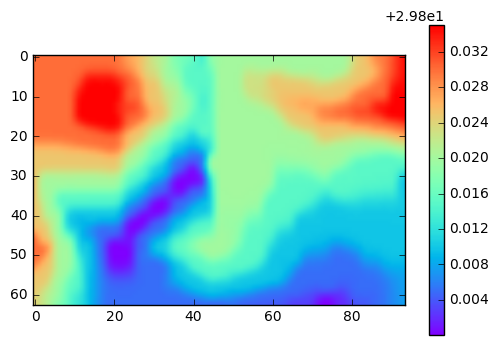

In [21]:
plt.imshow(zcc[1:-1, 1:-1].T, cmap = "rainbow")
plt.colorbar()
